<a href="https://colab.research.google.com/github/hmzakt/MNIST-Deep-Learning-model/blob/main/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
  print("using GPU")
device

2.6.0+cu124


'cpu'

## Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [4]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None   # This is used to one hot encode the labels
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

len(train_data), len(test_data)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


(60000, 10000)

## Visualize at least 5 different samples of the MNIST training dataset.

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

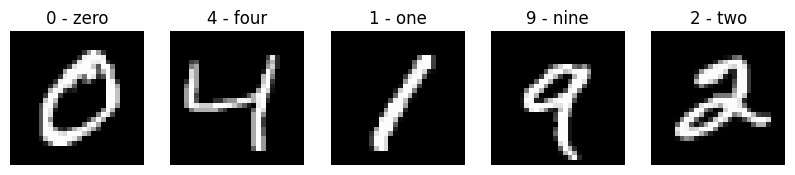

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
rows, cols = 1,5
for i in range(1, rows*cols+1):
  img, label = train_data[i]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [19]:
from torch.utils.data import DataLoader
batch_size = 32

train_dataloader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False
)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [20]:
x = train_features_batch[0]
x.shape

torch.Size([1, 28, 28])

In [24]:
from torch import nn

flatten_model = nn.Flatten()
output = flatten_model(x)

output.shape

torch.Size([1, 784])

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [68]:
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device : torch.device = device):

  train_loss, train_acc = 0.0, 0.0 # Initialize as floats

  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item() # Accumulate loss as a float
    train_acc += accuracy_fn(y_pred.argmax(dim=1),y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0 :
      print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples") # Use data_loader.dataset

  # divide total train loss and ac by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")


def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):
  test_loss, test_acc = 0.0, 0.0 # Initialize as floats

  model.eval()

  with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X)

      test_loss += loss_fn(y_pred,y ).item() # Accumulate loss as a float
      test_acc += accuracy_fn(y_pred.argmax(dim=1),y)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

In [69]:
class MNISTModel(nn.Module) :
  def __init__(self , input_shape : int, hidden_units: int, output_shape : int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride =1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return self.classifier(x)

In [70]:
model = MNISTModel(input_shape = 1,
                   hidden_units = 10,
                   output_shape = len(class_names)).to(device)

## Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [71]:
# Measure time
from timeit import default_timer as timer
from tqdm.auto import tqdm
from helper_functions import accuracy_fn, print_train_time
import torch.optim as optim
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)
train_time_start_model_2 = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.38895 | Train acc: 86.46
Test loss: 0.08667 | Test acc: 97.15
Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.07797 | Train acc: 97.62
Test loss: 0.06304 | Test acc: 97.94
Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.05903 | Train acc: 98.16
Test loss: 0.04750 | Test acc: 98.46
Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.04902 | Train acc: 98.48
Test loss: 0.03794 | Test acc: 98.67
Epoch: 4
---------
Looked at 0/60000

## Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [77]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [78]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 4 (4 - four)


In [81]:
pred_probs= make_predictions(model=model,
                             data=test_samples)

In [82]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 6, 3, 9, 5, 8, 8, 2, 1])

In [83]:
test_labels, pred_classes

([4, 6, 3, 9, 5, 8, 8, 2, 1], tensor([4, 6, 3, 9, 5, 8, 8, 2, 1]))

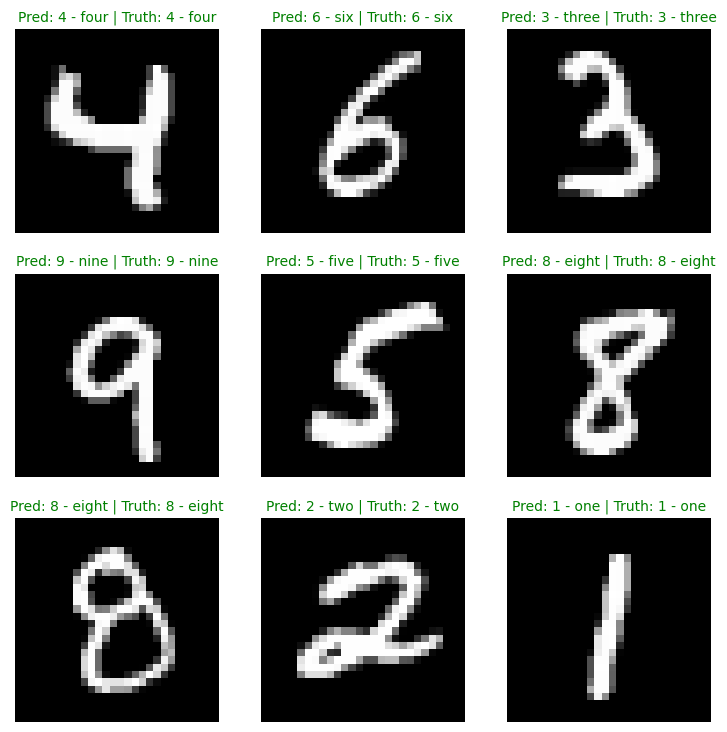

In [86]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## Plot a confusion matrix comparing your model's predictions to the truth labels.

In [90]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [93]:
# plotting the matrix
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 865.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
mlxtend version: 0.23.4


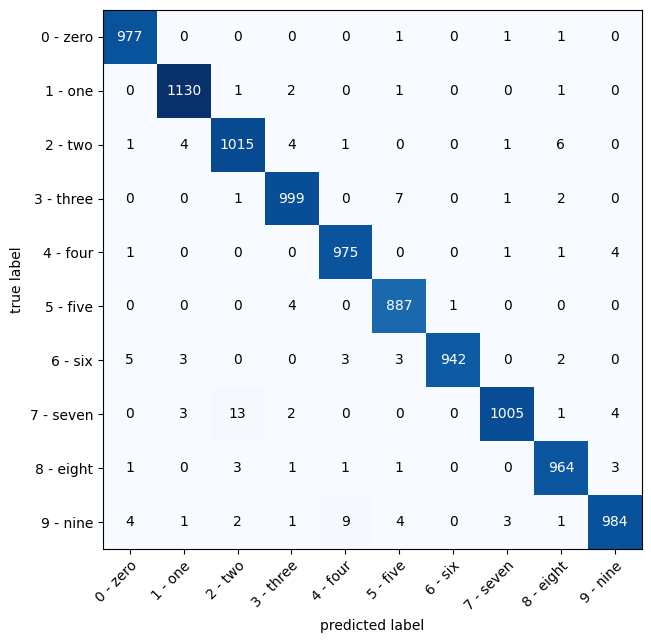

In [95]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [96]:
import torch
from torch import nn

# Create a random tensor
random_tensor = torch.randn(1, 3, 64, 64)
print(f"Input tensor shape: {random_tensor.shape}")

# Define a Conv2d layer with a kernel size of 3
conv_layer_3 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
output_tensor_3 = conv_layer_3(random_tensor)
print(f"Output tensor shape with kernel_size=3: {output_tensor_3.shape}")

# Define a Conv2d layer with a kernel size of 5
conv_layer_5 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
output_tensor_5 = conv_layer_5(random_tensor)
print(f"Output tensor shape with kernel_size=5: {output_tensor_5.shape}")

# Define a Conv2d layer with a kernel size of 1
conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
output_tensor_1 = conv_layer_1(random_tensor)
print(f"Output tensor shape with kernel_size=1: {output_tensor_1.shape}")

# What do you notice?
print("\nObservations:")
print("As the kernel_size increases, the spatial dimensions (height and width) of the output tensor decrease.")
print("A larger kernel covers a wider area of the input, resulting in a smaller output size for the same stride and padding.")
print("A kernel_size of 1 acts like a 1x1 convolution, only changing the number of channels if out_channels is different from in_channels, without affecting the spatial dimensions (if padding is 0).")

Input tensor shape: torch.Size([1, 3, 64, 64])
Output tensor shape with kernel_size=3: torch.Size([1, 16, 62, 62])
Output tensor shape with kernel_size=5: torch.Size([1, 16, 60, 60])
Output tensor shape with kernel_size=1: torch.Size([1, 16, 64, 64])

Observations:
As the kernel_size increases, the spatial dimensions (height and width) of the output tensor decrease.
A larger kernel covers a wider area of the input, resulting in a smaller output size for the same stride and padding.
A kernel_size of 1 acts like a 1x1 convolution, only changing the number of channels if out_channels is different from in_channels, without affecting the spatial dimensions (if padding is 0).


Saving the model

In [98]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "MnistModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

In [103]:
loaded_model = MNISTModel(input_shape=1,
                                    hidden_units=10,
                                    output_shape=10)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model = loaded_model.to(device)